<a href="https://colab.research.google.com/github/rishubhkhurana/EVA2/blob/master/S2/QuadsAndBirds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quads Vs Birds
Image Classification using Mobile Net V2.

### Downloading Libs


In [1]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 703.8MB 25kB/s 
     |████████████████████████████████| 6.6MB 2.3MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


### Importing Libs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torchvision.utils import save_image,make_grid
from torchvision.datasets import ImageFolder, DatasetFolder
from PIL import Image
import cv2
import torchvision.transforms as transforms
import numpy as np
from collections import Counter
from fastprogress import progress_bar
from torch.utils.data import random_split,DataLoader
from albumentations import PadIfNeeded,Resize,Compose,CenterCrop
import matplotlib.pyplot as plt
import time
import shutil,os
from functools import partial
from torchsummary import summary
import torch.nn as nn
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import sys

In [5]:
sys.path.append('/content/drive/My Drive/Vision')
sys.path.append('/content/drive/My Drive/')

In [6]:
from Vision import *

In [7]:
!cp -R /content/drive/My\ Drive/OutputData.zip .

In [ ]:
!unzip OutputData.zip

### Reading Dataset


In [9]:
#datapath = '/content/Session2'
traindatapath = '/content/OutputData/train'
validdatapath = '/content/OutputData/val'

In [ ]:
#tfms = transforms.Compose([transforms.ToTensor()])
ds1 = ImageFolder(root=traindatapath)#,transform=tfms) 


In [ ]:
ds1.classes

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']

In [ ]:
all_files = []
extensions=[]
for r,_,filenames in os.walk(traindatapath):
    all_files.extend(filenames)
    extensions.extend([f.split('.')[-1] for f in filenames])

In [ ]:

Counter(extensions),

(Counter({'jpg': 12089}),)

In [ ]:
ds1 = DatasetFolder(root=traindatapath,loader = lambda x: Image.open(x),extensions=('jpg','jpeg'))

In [ ]:
len(ds1)

12089

In [ ]:
np.bincount(ds1.targets)

array([6059,  708, 2258, 3064])

### Dataset Transform

In [10]:
def resize(img,size=(256,256),default_scaling=False):
    """
    Resize the image to the given size.
    """
    # width and height of image
    w,h = img.size
    # get the maximum of the sides
    w_new,h_new = size
    if w<h:
        w_new = int(w*size[0]/h)
    else:
        h_new = int(h*size[0]/w)
    if isinstance(img,Image.Image):
        img = np.asarray(img)
    if img.shape[-1]==1 or len(img.shape)==2:
        img = np.stack([img,img,img],axis=-1)
    if img.shape[-1]==4:
        img = img[:,:,:-1]
    if not default_scaling:
        img = Compose([Resize(h_new,w_new),PadIfNeeded(min_height=size[0],min_width=size[1]),CenterCrop(224,224)])(image=img)['image']
    else:
        img = Compose([Resize(size[0],size[1]),PadIfNeeded(min_height=size[0],min_width=size[1]),CenterCrop(224,224)])(image=img)['image']
    return img

In [11]:
tfms = transforms.Compose([transforms.Lambda(partial(resize,default_scaling=False)),transforms.ToPILImage(),transforms.ToTensor()])

### Data Loader

In [12]:
tds = DatasetFolder(root=traindatapath,loader = lambda x: Image.open(x),extensions=('jpg'),transform=tfms)

In [13]:
dl = DataLoader(tds,batch_size=128,shuffle=True,num_workers=4)

In [14]:
def show_batch(dl,nrow=4,num_images=16):
    batch = next(iter(dl))
    img = np.transpose(make_grid(batch[0].cpu()[:num_images],nrow=nrow).numpy(),(1,2,0))
    plt.figure(figsize=(16,8))
    plt.imshow(img)



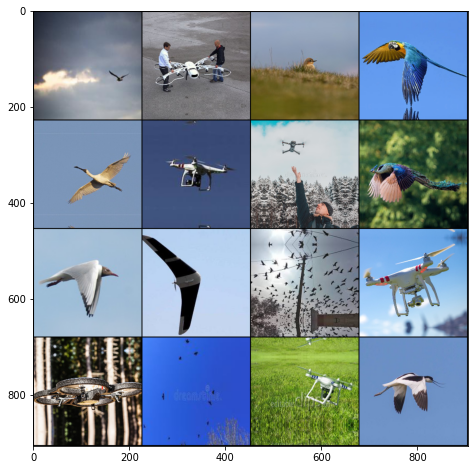

In [15]:
show_batch(dl)

### Data Normalization

In [16]:
means = []
sqs = []
count=[]
for i,(x,_) in progress_bar(enumerate(dl),total=len(dl)):
    count.append(x.shape[0])
    means.append(x.mean((0,2,3)).numpy())
    sqs.append((x**2).mean((0,2,3)).numpy())

In [17]:
all_means=(np.stack(means)*np.array(count).reshape(-1,1)).sum(0)/sum(count)

In [18]:
all_sqs=(np.stack(sqs)*np.array(count).reshape(-1,1)).sum(0)/sum(count)

In [19]:
all_stds = np.sqrt(all_sqs-all_means**2)

In [20]:
all_stds,all_means

(array([0.27176529, 0.25019363, 0.29461647]),
 array([0.52867616, 0.58003509, 0.61068508]))

### Applying Normalization + Data Splitting + data loader

In [24]:
tfms = transforms.Compose([transforms.Lambda(partial(resize,default_scaling=False)),transforms.ToPILImage(),transforms.ToTensor(),
                           transforms.Normalize(mean=all_means,std=all_stds)])

In [22]:
train_ds = DatasetFolder(root=traindatapath,loader = lambda x: Image.open(x),extensions=('jpg'),transform=tfms)
valid_ds = DatasetFolder(root=validdatapath,loader = lambda x: Image.open(x),extensions=('jpg'),transform=tfms)


In [23]:
len(train_ds),len(valid_ds)

(12089, 3025)

In [89]:
np.bincount(train_ds.targets)+ np.bincount(valid_ds.targets)

array([7574,  886, 2823, 3831])

In [25]:
BATCH_SIZE = 128
dls = dict()
dataloader_args = dict(shuffle=True,pin_memory=True,batch_size=BATCH_SIZE,num_workers=4)
dls['train'] = DataLoader(train_ds,**dataloader_args)
dataloader_args = dict(shuffle=False,pin_memory=True,batch_size=BATCH_SIZE*2,num_workers=4)
dls['valid'] = DataLoader(valid_ds,**dataloader_args)

### Model 

In [ ]:
model = models.CustomMobileNet(num_classes=4).cuda()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
summary(model,input_size=(3,224,224),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### Finding LR

In [90]:
model1 = models.CustomMobileNet(num_classes=4).cuda()
opt = torch.optim.Adam(model1.parameters())
loss_func = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [91]:
finder = train.LRFinder(model1,opt,criterion=loss_func)

In [92]:
finder.range_test(dls['train'],num_iter=500)


 51%|█████▏    | 257/500 [08:12<09:03,  2.24s/it]

Stopping early as the loss has started to diverge
Learning rate search is over. Please use self.plot to look at the graph


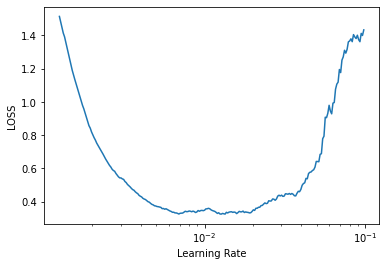

In [94]:
finder.plot()

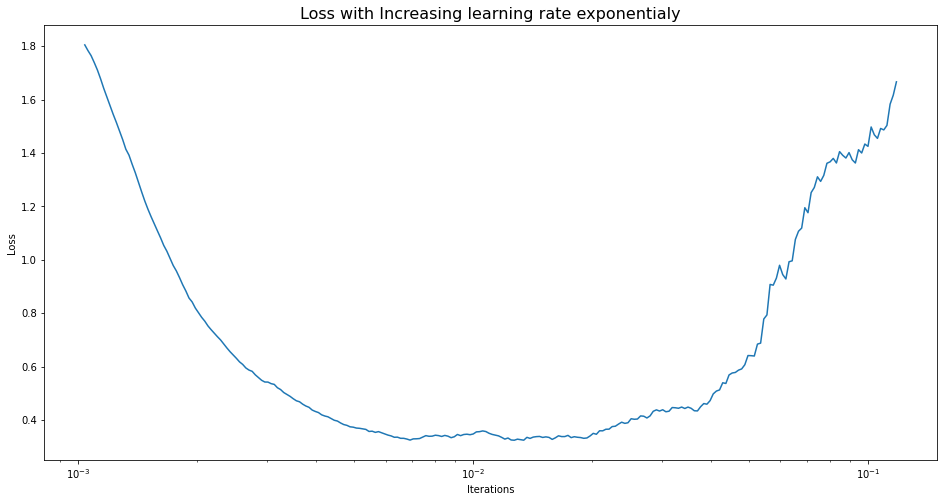

In [98]:
fig = plt.figure(figsize=(16,8))
plt.plot(finder.history['lr'],finder.history['loss'])
plt.xscale('log')
plt.xlabel('Iterations',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.title('Loss with Increasing learning rate exponentialy',fontsize=16)
plt.savefig('finder.png')

In [31]:
del model,finder


### Training Model

In [32]:
model = models.CustomMobileNet(num_classes=4).cuda()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [33]:
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [34]:
criterion = nn.CrossEntropyLoss()

In [35]:
#sched = train.get_scheduler(opt,'reduce',patience=3,verbose=True)
sched = train.get_scheduler(opt,'onecycle',max_lr=2e-3,epochs=30,steps_per_epoch = len(dls['train']),div_factor=25,final_div_factor=50)

1 (2,)


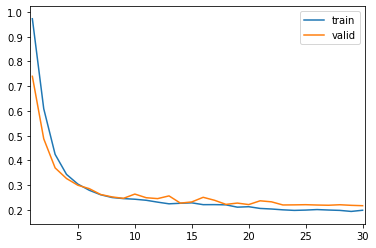

2 (4,)
3 (6,)
4 (8,)
5 (10,)
6 (12,)
7 (14,)
8 (16,)
9 (18,)
10 (20,)
11 (22,)
12 (24,)
13 (26,)
14 (28,)
15 (30,)
16 (32,)
17 (34,)
18 (36,)
19 (38,)
20 (40,)
21 (42,)
22 (44,)
23 (46,)
24 (48,)
25 (50,)
26 (52,)
27 (54,)
28 (56,)
29 (58,)
30 (60,)


In [36]:
results = train.train(model,opt,dls,n_epochs=30,loss_func=criterion,scheduler=sched,sched_loss=True,device='cuda',sched_batchwise=True)

In [ ]:
modelpath = '/content/drive/My Drive/EVA/model_optimized.pt'

In [ ]:
torch.save(model.state_dict(),modelpath)

In [ ]:
cpu_model = model.to('cpu')

In [ ]:
cpu_model.eval()

CustomMobileNet(
  (model): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [ ]:
cpu_model = torch.jit.trace(cpu_model,torch.randn(1,3,224,224))

In [ ]:
cpu_model.save('/content/drive/My Drive/EVA/model_optimized_jit.pt')

In [ ]:
cpu_model.save('model_v1.pt')

### Diagnostics

In [38]:
import matplotlib.pyplot as plt

In [39]:
results.keys()

dict_keys(['TrainingLosses', 'ValidationLosses', 'TrainingAccuracy', 'ValidationAcc', 'TrainingBatchLosses', 'ValidationBatchLosses'])

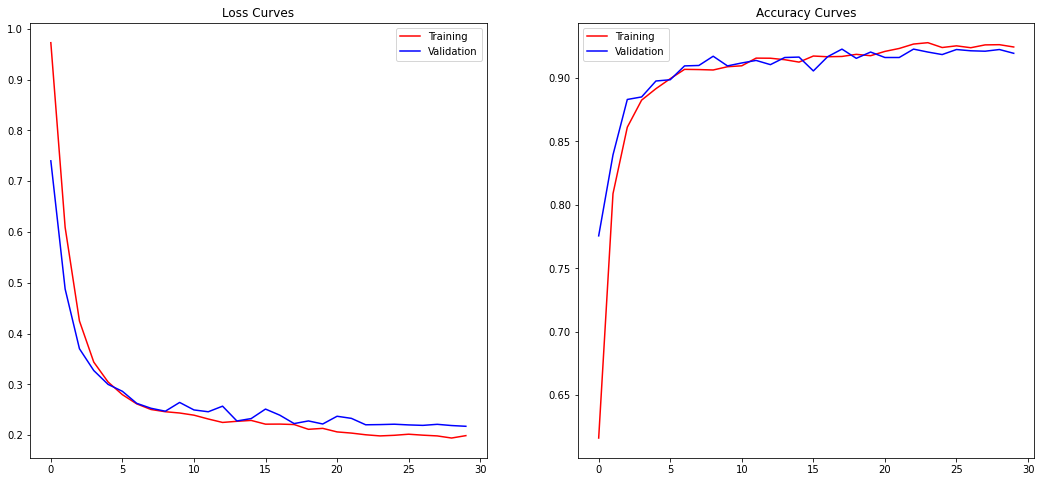

In [49]:
fig=plt.figure(figsize=(18,8))
axs = fig.add_subplot(1,2,1)
axs.plot(results['TrainingLosses'],c='r',label='Training')
axs.plot(results['ValidationLosses'],c='b',label='Validation')
axs.legend(loc='best')
axs.set_title('Loss Curves')
axs = fig.add_subplot(1,2,2)
axs.plot(results['TrainingAccuracy'],c='r',label='Training')
axs.plot(results['ValidationAcc'],c='b',label='Validation')
axs.legend(loc='best')
axs.set_title('Accuracy Curves')
plt.savefig('training_curves.png')

In [51]:
_=model.eval()

In [52]:
test_results = test.top5errors(model,dls['valid'])
test_results['probs'] = np.concatenate(test_results['probs'])


In [53]:
train_results = test.top5errors(model,dls['train'])
train_results['probs'] = np.concatenate(train_results['probs'])


In [54]:
print(f"Validation accuracy --> {np.equal(test_results['preds'],test_results['groundtruths']).mean()}")
print(f"Training Accuracy --> {np.equal(train_results['preds'],train_results['groundtruths']).mean()}")

Validation accuracy --> 0.9193388429752066
Training Accuracy --> 0.9478037885681198


In [55]:
cm_train=confusion_matrix(train_results['groundtruths'],train_results['preds'])#,labels=train_ds.dataset.classes)
cm_test=confusion_matrix(test_results['groundtruths'],test_results['preds'])#,labels=train_ds.dataset.classes)

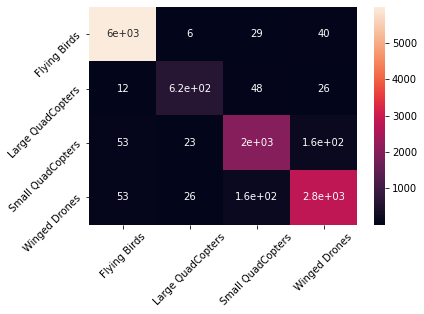

In [ ]:
ax=sns.heatmap(cm_train,annot=True)
ax.set_xticklabels(train_ds.classes)
ax.tick_params(axis='x', rotation=45)
ax.set_yticklabels(train_ds.classes)
ax.tick_params(axis='y', rotation=45)


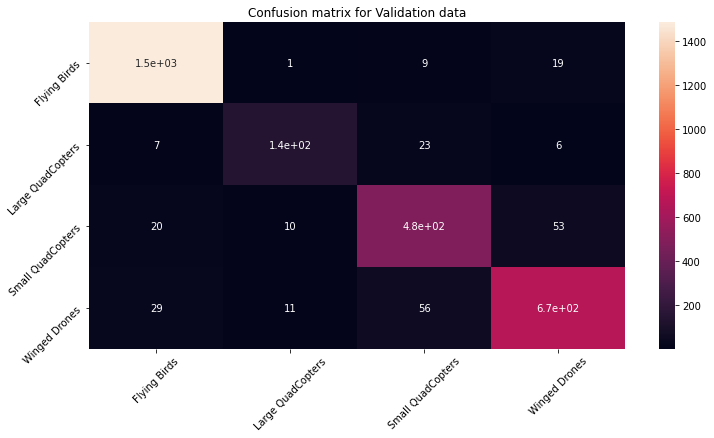

In [56]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax=sns.heatmap(cm_test,annot=True,ax=ax)
ax.set_xticklabels(train_ds.classes)
ax.tick_params(axis='x', rotation=45)
ax.set_yticklabels(train_ds.classes)
ax.tick_params(axis='y', rotation=45)
ax.set_title("Confusion matrix for Validation data")
plt.savefig('confusion_matrix.png')
plt.show()

In [77]:
import re

In [110]:
# lowest probability
incorr_birds_test = np.where(np.logical_and(test_results['preds']!=0,test_results['groundtruths']==0))[0]
incorr_large_test = np.where(np.logical_and(test_results['preds']!=1,test_results['groundtruths']==1))[0]
incorr_small_test = np.where(np.logical_and(test_results['preds']!=2,test_results['groundtruths']==2))[0]
incorr_winged_test = np.where(np.logical_and(test_results['preds']!=3,test_results['groundtruths']==3))[0]
all_classes = []
all_idxs =[]
all_probs=[]
for i,(c,v) in enumerate(zip(valid_ds.classes,[incorr_birds_test,incorr_large_test,incorr_small_test,incorr_winged_test])):
    all_classes.extend([c]*v.shape[0])
    all_idxs.extend(v)
    all_probs.extend(test_results['probs'][v,i])
incorr_test_df = pd.DataFrame({'objectclass':all_classes,
                                'incorrect_idxs':np.concatenate([incorr_birds_test,incorr_large_test,incorr_small_test,incorr_winged_test]),
                                'probs':all_probs})

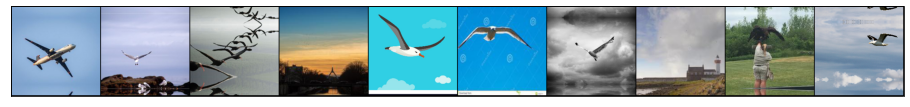

In [119]:
c='Flying Birds'
idxs = incorr_test_df[incorr_test_df.loc[:,'objectclass']==c].sort_values(by='probs')['incorrect_idxs'][:10].values
temp_probs = incorr_test_df[incorr_test_df.loc[:,'objectclass']==c].sort_values(by='probs')['probs'][:10].values
images = torch.stack([valid_ds[idxs[j]][0] for j in range(10)])
fig=plt.figure(figsize=(16,8))
grid = make_grid(images,nrow=10)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.xticks([])
plt.yticks([])
name = re.sub(r'\s+','_',c.lower())
plt.savefig(f"error_images_{name}.png")


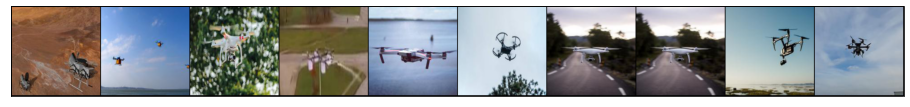

In [120]:
c='Large QuadCopters'
idxs = incorr_test_df[incorr_test_df.loc[:,'objectclass']==c].sort_values(by='probs')['incorrect_idxs'][:10].values
temp_probs = incorr_test_df[incorr_test_df.loc[:,'objectclass']==c].sort_values(by='probs')['probs'][:10].values
images = torch.stack([valid_ds[idxs[j]][0] for j in range(10)])
plt.figure(figsize=(16,8))
grid = make_grid(images,nrow=10)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.xticks([])
plt.yticks([])
name = re.sub(r'\s+','_',c.lower())
plt.savefig(f"error_images_{name}.png")
_=plt.show()

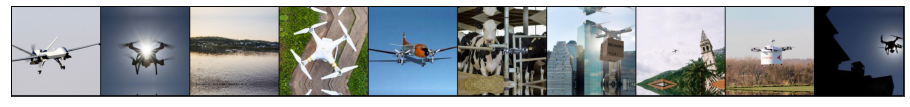

In [121]:
c='Small QuadCopters'
idxs = incorr_test_df[incorr_test_df.loc[:,'objectclass']==c].sort_values(by='probs')['incorrect_idxs'][:10].values
temp_probs = incorr_test_df[incorr_test_df.loc[:,'objectclass']==c].sort_values(by='probs')['probs'][:10].values
images = torch.stack([valid_ds[idxs[j]][0] for j in range(10)])
plt.figure(figsize=(16,8))
grid = make_grid(images,nrow=10)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.xticks([])
plt.yticks([])
name = re.sub(r'\s+','_',c.lower())
plt.savefig(f"error_images_{name}.png")
_=plt.show()

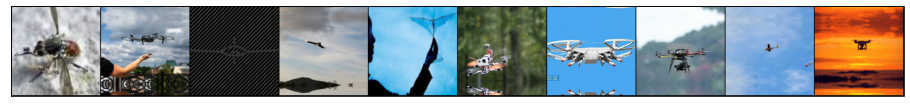

In [122]:
c='Winged Drones'
idxs = incorr_test_df[incorr_test_df.loc[:,'objectclass']==c].sort_values(by='probs')['incorrect_idxs'][:10].values
temp_probs = incorr_test_df[incorr_test_df.loc[:,'objectclass']==c].sort_values(by='probs')['probs'][:10].values
images = torch.stack([valid_ds[idxs[j]][0] for j in range(10)])
plt.figure(figsize=(16,8))
grid = make_grid(images,nrow=10)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.xticks([])
plt.yticks([])
name = re.sub(r'\s+','_',c.lower())
plt.savefig(f"error_images_{name}.png")
_=plt.show()